### Problem Set 03: MDPs and Activity Planning

In this problem set you will implement value iteration in a non-deterministic MDP, and work through some activity planning problems.


0. [Credit for Contributors (required)](#contributors)

1. [Non-deterministic MDPs](#problem1)
    1. [Value Iteration (25 points)](#v_iteration)
    2. [Extract the Policy from V* (15 points)](#v_to_policy)
    3. [Policy Observations (20 points)](#policy_observations)
2. [Activity Planning](#problem2)
    1. [Defining Predicates (5 points)](#predicates)
    2. [Problem Formulation (5 points)](#problem_form)
    3. [Relaxed Plan Graph and FF Heuristic (20 points)](#relaxed)
    
**90 points** total for Problem Set 3

## <a name="contributors"></a> Credit for Contributors

List the various students, lecture notes, or online resouces that helped you complete this problem set:

Ex: I worked with Bob on the cat activity planning problem.

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

AIMA Fig 17.6
6.3900 Spring 2023 HW 10 (I took the class that semester, only looked at my own past work and class notes)

In [2]:
# Useful imports
from __future__ import division

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
from nose.tools import ok_, assert_equal, assert_almost_equal
from grid import MDPGrid, generate_mdp_plot
from mdp_utils import MDP, build_mdp

## <a name="problem1"></a> Problem 1: Non-deterministic MDPs (60 points)

In this problem you will implement value iteration in a non-deterministic MDP grid world in order to compute the optimal policy. You will then plot the results and discuss your observations for different parameters of the MDP model.

We are giving you a simple MDP class that you can use for this problem. This class is defined in the `mdp_utils.py` file. You should open this file now to look at the class definition: especially at the properties of MDP (S, A, T, R, $\gamma$).

The non-deterministic MDP model that we'll use in this problem is the same one described in chapter 17.1 of the AIMA book.

Basically, the robot is in a grid world and can perform four actions at any time: `up`, `down`, `right` and `left`. However, because it's not a deterministic world, the outcome of these actions is not perfect. After executing an action, the robot will move in its intended direction with probability `p`. However, with probability `1-p` it will move at right angles to the intended direction. However, note that if the outcome of the action makes the robot bump into the walls of the world, the robot will bounce back and stay in the same state. For example, from the state `(1,1)`, the action `up` moves the agent to `(1,2)` with probability 0.8, but with probability 0.1, it moves right to `(2,1)`, and with probability 0.1, it moves left, bumps into the wall, and stays in `(1,1)`.

The world is an `n x n` grid. There is a terminal goal cell. The robot receives reward `goal_reward` when arriving to the goal cell from any other neighbor cell. Similarly, there are obstacle cells. The robot receives (negative) reward `obstacle_reward` when arriving to these cells. Both the goal and the obstacle cells are terminal: the robot can't leave these cells once it lands on them.

The goal is to find the optimal policy for the robot.

Luckily (for you), we are providing the function build_mdp that generates the MDP for this grid world.

```
def build_mdp(n, p, obstacles, goal, gamma, goal_reward=100, obstacle_reward=-1000)
```





The following example generates an MDP for the following `3x3` grid with goal state `(2,2)` (green circle) and obstacle in `(0,1)` (black circle).

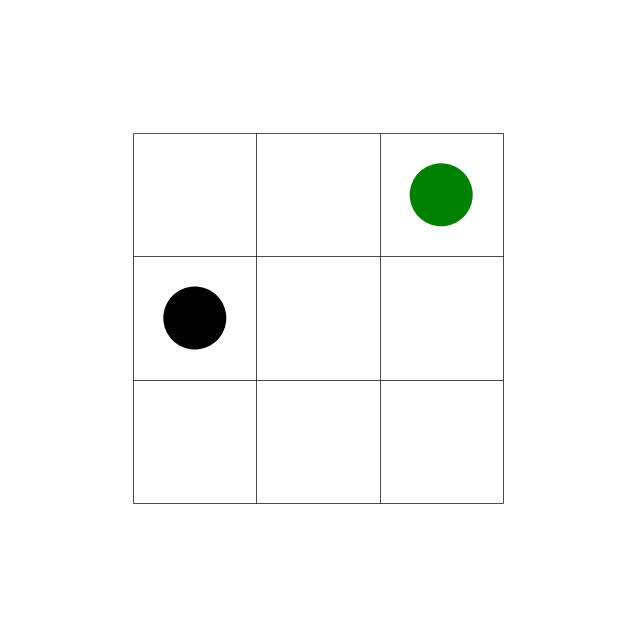

In [3]:
n = 3
goal = (2,2)
obstacles = [(0,1)]

# Build MDP
mdp = build_mdp(n, 0.8, obstacles, goal, 0.8)

# Create grid for plotting
g = MDPGrid(n,n)
axes = g.draw()
# Draw goal and obstacle cells
g.draw_cell_circle(axes, goal, color='g')
for ob in obstacles:
    g.draw_cell_circle(axes, ob, color='k')
    

The print command prints the information about the MDP that we just generated (MDP models get large pretty fast).

In [4]:
# Print info about MDP model that we just generated.
mdp.print_mdp()

MDP: 
  States (9): '(0, 1)', '(1, 2)', '(2, 1)', '(0, 0)', '(1, 1)', '(2, 0)', '(0, 2)', '(2, 2)', '(1, 0)'
  Actions (4): ['up', 'down', 'right', 'left']
  Transitions:
   + State '(0, 0)'
     -action 'up'
       to '(0, 1)' with p=0.80
       to '(1, 0)' with p=0.10
       to '(0, 0)' with p=0.10
     -action 'down'
       to '(0, 0)' with p=0.90
       to '(1, 0)' with p=0.10
     -action 'right'
       to '(1, 0)' with p=0.80
       to '(0, 1)' with p=0.10
       to '(0, 0)' with p=0.10
     -action 'left'
       to '(0, 0)' with p=0.90
       to '(0, 1)' with p=0.10
   + State '(0, 1)'
     -action 'up'
       to '(0, 1)' with p=1.00
     -action 'down'
       to '(0, 1)' with p=1.00
     -action 'right'
       to '(0, 1)' with p=1.00
     -action 'left'
       to '(0, 1)' with p=1.00
   + State '(0, 2)'
     -action 'up'
       to '(0, 2)' with p=0.90
       to '(1, 2)' with p=0.10
     -action 'down'
       to '(0, 1)' with p=0.80
       to '(1, 2)' with p=0.10
       to '(0, 

### <a name="v_iteration"></a> Implement Value Iteration (25 points)

In this part of the problem you will implement **value iteration** for a given MDP.

Your function should have the following signature:

```python
def value_iteration(mdp, epsilon=1e-3)
```

The function should take an MDP instance (like the generated by the `build_mdp` function) and a value for `epsilon` that you'll use to determine when to stop value iteration (as explained in the lecture notes).

The function should return a Python dictionary with the optimal value for each state in the MDP. Your function should also print how many iterations it took to reach convergence for the given epsilon value.

As an example of what your function should return, have a look at what a random Value function would look like.

In [5]:
def random_V(mdp):    
    states = mdp.S
    V_random = dict()
    minV, maxV = -100, 100
    random_values = np.random.uniform(minV, maxV, [len(states), 1])
    for i, s in enumerate(states):
        V_random[s] = random_values[i]
    return V_random
print("V_random is a valid Value function, although definitely not optimal (it's just random!)")
mdp = build_mdp(n, 0.8, [], (1, 1), 0.8)
V_random = random_V(mdp)
V_random

V_random is a valid Value function, although definitely not optimal (it's just random!)


{(0, 1): array([-1.1531026]),
 (1, 2): array([80.97320946]),
 (2, 1): array([-29.67196955]),
 (0, 0): array([37.02449087]),
 (1, 1): array([33.02754418]),
 (2, 0): array([-75.18684408]),
 (0, 2): array([54.16433538]),
 (2, 2): array([8.07251637]),
 (1, 0): array([-60.17638589])}

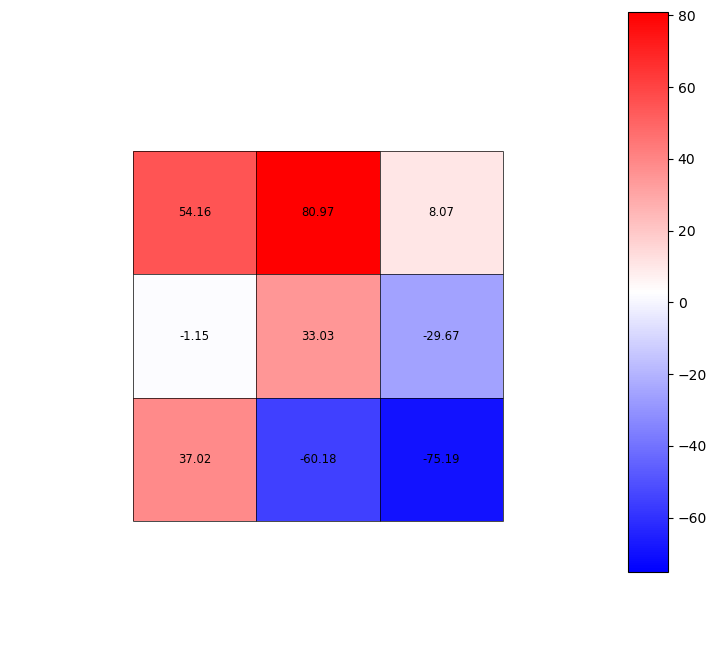

In [6]:
# The previous random V can be plotted in the grid.
n = 3
# Create grid for plotting
g = MDPGrid(n, n)
axes = g.draw()
# Plot V in the grid
g.plot_V(axes, V_random, print_numbers = True)

<div class="alert alert-info">
Implement function `value_iteration(mdp, epsilon=1e-3)` below.
</div>

<div class="alert alert-warning">
**Note**: Assume that if some some combination of `s`, `a` and `s_dest` is not found in the `reward` of the MDP (that is, you get an error when trying to access `mdp.R[s][a][s_dest]`, then the reward should be 0.
</div>

In [93]:
# Write your code for value iteration in this cell

# YOUR CODE HERE
def value_iteration(mdp, epsilon=1e-3):
    values = dict()
    for s in mdp.S:
       values[s] = 0
    iters = 0
    while True:
        iters+=1
        new_vals = values.copy()
        maxdiff = 0
        for s in mdp.S:
            maxv = 0
            for a in mdp.A:
                rfora = 0
                for sp in mdp.S:
                    try:
                        rfora += mdp.R[s][a][sp]+mdp.gamma*values[sp]*mdp.T[s][a][sp]
                    except:
                        pass
                if rfora > maxv:
                    maxv = rfora
            new_vals[s] = maxv
            if abs(values[s]-new_vals[s]) > maxdiff:
                maxdiff = abs(values[s] - new_vals[s])
        if maxdiff < epsilon:
            print("number of iterations: ",iters)
            return new_vals
        values = new_vals

number of iterations:  42
V:



{(0, 1): 0,
 (1, 2): 207.21635350468995,
 (2, 1): 217.80026781239866,
 (0, 0): 9.4847231278406,
 (1, 1): 165.45420280815097,
 (2, 0): 148.87689452777576,
 (0, 2): 16.577308280375195,
 (2, 2): 0,
 (1, 0): 118.55903909800752}

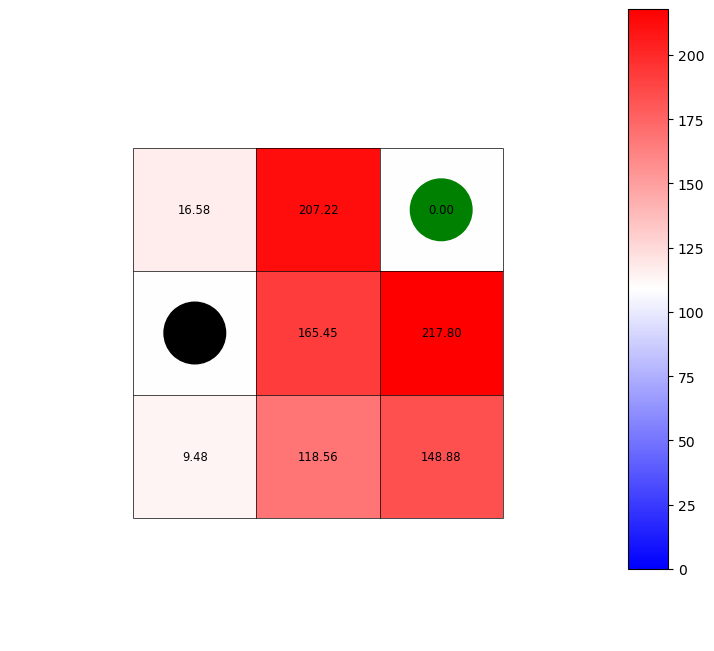

In [94]:
# Test your code for value iteration with the example from before
# Don't modify this cell (it may be overwritten)
n = 3
goal = (2, 2)
obstacles = [(0, 1)]

# Build MDP
mdp = build_mdp(n, 0.8, obstacles, goal, 0.8)

# Create grid for plotting
g = MDPGrid(n, n)
axes = g.draw()
# Perform value iteration
V = value_iteration(mdp, epsilon=1e-3)
g.plot_V(axes, V, print_numbers=True)
# Draw goal and obstacle cells
g.draw_cell_circle(axes, goal, color='g')
for ob in obstacles:
    g.draw_cell_circle(axes, ob, color='k')
print("V:\n")
V


### <a name="v_to_policy"></a> Extract the policy from V* (15 points)

Create function `extract_policy(mdp, V)` that extracts the optimal policy from V. The output of this function should be a Python dictionary mapping each state to the best action to take (e.g. `up`,`down`,`right`,`left`)

The following shows a simple random policy that will give you an idea of the format that the `extract_policy` function should produce.

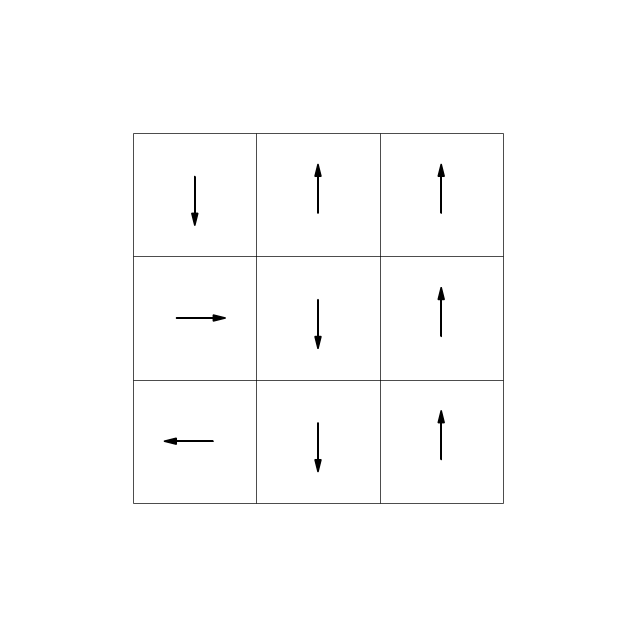

In [40]:
def random_policy(mdp):
    states = mdp.S
    actions = mdp.A
    Pi_random = dict()
    random_values = np.random.randint(0, len(actions),[len(states), 1])
    
    for i, s in enumerate(states):
        Pi_random[s] = actions[int(random_values[i])]
        
    return Pi_random

# The previous random V can be plotted in the grid.
n = 3
mdp = build_mdp(n, 0.8, [], (1,1), 0.8)
g = MDPGrid(n,n)
axes = g.draw()

Pi_random = random_policy(mdp)
g.plot_policy(axes, Pi_random)

<div class="alert alert-info">
Implement function `extract_policy(mdp, V)` below.
</div>

In [90]:
# Write your code for the policy extraction in this cell

def extract_policy(mdp, V):
    # YOUR CODE HERE
    policy = dict()
    for s in mdp.S:
        maxval = 0
        bestact = None
        for a in mdp.A:
            sumval = 0
            for sp in mdp.S:
                try:
                    sumval += mdp.R[s][a][sp]+mdp.gamma*V[sp]*mdp.T[s][a][sp]
                except:
                    pass
            if sumval > maxval:
                maxval = sumval
                bestact = a
        policy[s] = bestact
        if policy[s] is None:
            policy[s] = a
    return policy


Now we'll test both your optimal policy in the example we have been using. Execute but, don't modify, the following cell.

number of iterations:  42


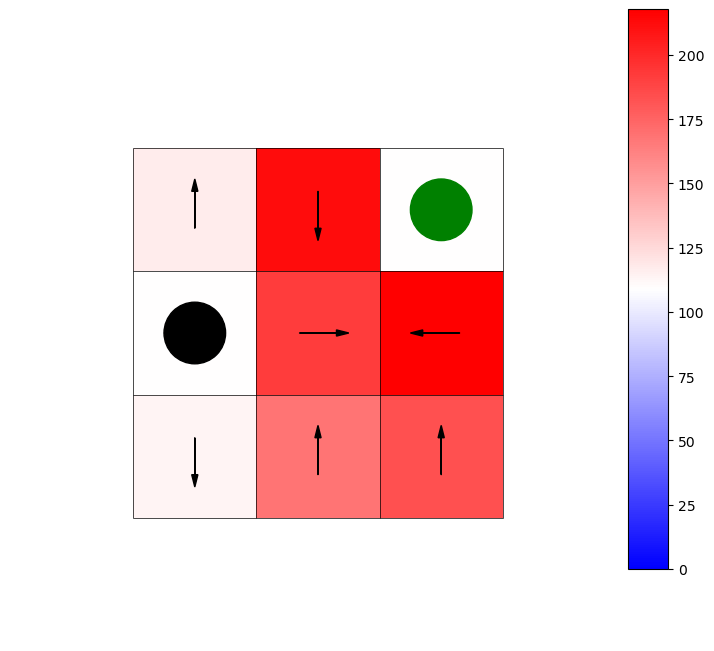

In [95]:
# Test your code for value iteration with the example from before
# Don't modify this cell (it may be overwritten)
n = 3
goal = (2,2)
obstacles = [(0,1)]

# Build MDP
mdp = build_mdp(n, 0.8, obstacles, goal, 0.8)

# Create grid for plotting
g = MDPGrid(n, n)
axes = g.draw()
# Perform value iteration
V = value_iteration(mdp, epsilon=1e-3)
# Extract the policy
Pi = extract_policy(mdp, V)

g.plot_V(axes, V, print_numbers=False)
g.plot_policy(axes, Pi)

# Draw goal and obstacle cells
g.draw_cell_circle(axes, goal, color='g')
for ob in obstacles:
    g.draw_cell_circle(axes, ob, color='k')

### <a name="policy_observations"></a> Observations (20 points)

We'll now run your code on a larger grid with more obstacles.
Execute the following code:


number of iterations:  47


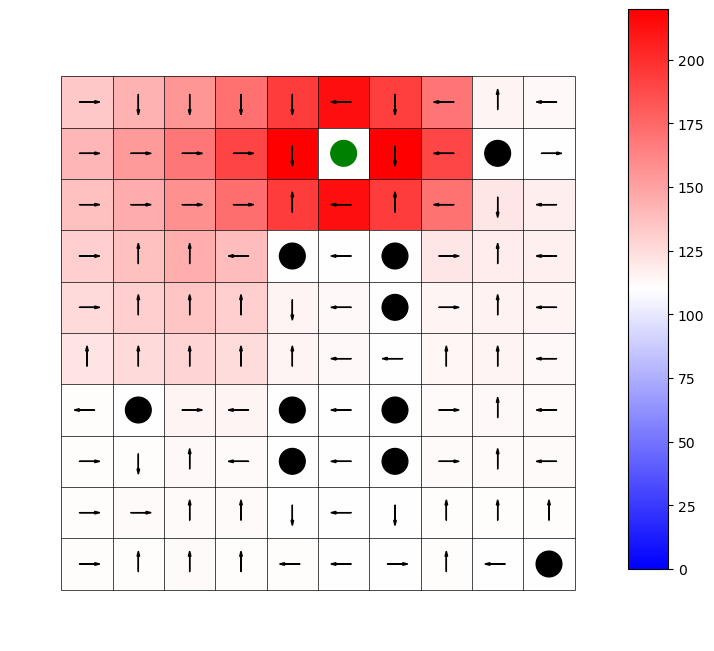

In [96]:
# Don't modify this code
n = 10
goal = (5,8)
# goal = (4,2)
obstacles = [(1,3), (9,0), (8,8)] + \
            [(4, 2), (4, 3), (4, 6)] + \
            [(6, 2), (6, 3), (6, 5), (6, 6)]
mdp = build_mdp(n, p=0.8, obstacles=obstacles, goal=goal, gamma=0.8, goal_reward=100, obstacle_reward=-500)
V = value_iteration(mdp)
Pi = extract_policy(mdp, V)
generate_mdp_plot(mdp, V, Pi, obstacles, goal)

number of iterations:  6


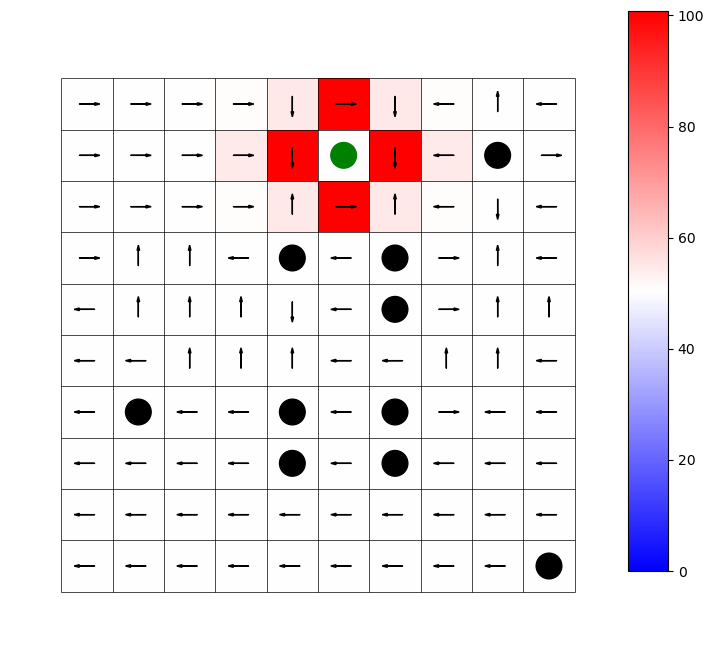

In [101]:
# Don't modify this code
n = 10
goal = (5,8)
# goal = (4,2)
obstacles = [(1,3), (9,0), (8,8)] + \
            [(4, 2), (4, 3), (4, 6)] + \
            [(6, 2), (6, 3), (6, 5), (6, 6)]
mdp = build_mdp(n, p=0.8, obstacles=obstacles, goal=goal, gamma=0.1, goal_reward=100, obstacle_reward=-500)
V = value_iteration(mdp)
Pi = extract_policy(mdp, V)
generate_mdp_plot(mdp, V, Pi, obstacles, goal)

What can you see? Does this policy look optimal? Does it look like the robot is doing something strange? Why? (hint: remember the transition model that we are using in this example)

<div class="alert alert-info">
**Discuss your results in the cell below**
</div>


I see a bunch of left arrows, which is very strange. The policy does not look optimal, but I think this is because the transition model is such that if one tries to go in a direction, the robot follows that only 80% of the time, and 90 degrees from the instructed to either side with even probability the rest of the time.

Try running the previous example with a couple variations of the values for `p`, `gamma` and the reward values.

How do this values affect the policy that we get?
(a brief qualitative answer is sufficient, no need for numerical analysis)


<div class="alert alert-info">
**Please discuss below**
</div>


With p=1, the bottom half of the grid opts to just go left. For a very low p, certain columns and rows seemed to favor up or down while the others favored right or left. With gamma=1, nearly the whole grid had comperable expected value of 100. With gamma=0.1, most of the grid except the four next to the goal had a lower expected value of around 50. The bottom half of the grid seemed to opt left, while the top half seemed to opt right.

## <a name="problem2"></a> Problem 2: Activity Planning

In this problem, we will model planning an observation for a spacecraft in orbit around Mars. Many older spacecraft were not designed with concurrency in mind, and so they required attitude (orientation) changes to point different instruments towards the Martian surface, the Earth, or the Sun. 

<img src=maven.png style="width: 80%;">


In our model, the orbiter has a sensor, a communications radar, solar cells for charging a battery, and a data cache. 

At any point in time, the orbiter may be:

- pointed at Mars (sensor pointed to surface for observations)
- pointed at Earth (radar pointed to Earth for transmission)
- pointed at the Sun (solar panels to Sun for charging)

These options are assumed to be mutually exclusive. We model attitude changes as requiring no power.

If the orbiter is pointed at the Sun, it may charge its battery to full. If the orbiter is pointed at Mars and has a full battery, it may make an observation. The observation empties the orbiter’s battery, but it gains data as a result. If the orbiter is pointed at Earth, has a full battery, and data in its cache, it may transmit data. Transmission of the data home empties the orbiter’s battery and the data cache. The objective of the mission is for the data to be sent back to Earth.

We will model the orbiter’s available actions as the following:
- Point at Earth
- Point at Mars
- Point at Sun
- Charge
- Observe
- Transmit 

### <a name="predicates"></a>Defining Predicates

Define the predicates for the problem, and define the preconditions and effects for each of the actions above. An example is given below. You may use the predicates in the example, but you are not obligated to.

**Observe:**

&nbsp;&nbsp;&nbsp;*Preconditions:* pointed-at-mars, battery-full

&nbsp;&nbsp;&nbsp;*Effects:* data-onboard, not battery-full 


Predicates represent statements that are always true or false, so something like (pointed == Mars), which is more like a variable that could have the values {Mars, Earth, Sun}, is invalid. 


1. Define your predicates to model the problem.

2. Write the preconditions and effects for each of the 6 actions.

3. Do your actions (preconditions and effects) prevent you from pointing at two places at the same time? You may assume the start state is only pointed at a single location.

4. The mission ends when the data has been transmitted. Can your predicates be used to indicate that the goal has been achieved?

You may upload handwritten work for any of the following answers, with the same instructions from Problem Set 2. You can use the html tag provided in the cell below by changing the name of the image file.


<div class="alert alert-info">
Write or upload your answer in the cell below this one.
</div>

1.
Predicates: pointed-at-earth, pointed-at-mars, pointed-at-sun, battery-full, data-onboard, data-sent
2.
preconditions; effects n\
point at Earth: - ; pointed-at-earth n\
point at Mars: - ; pointed-at-mars n\
point at Sun: - ; pointed-at-sun n\
charge: pointed-at-sun ; battery-full n\
observe: pointed-at-mars, battery-full; ¬battery-full, data-onboard n\
transmit: pointed-at-earth, battery-full, data-onboard; ¬battery-full, ¬data-onboard, data-sent n\
*unlisted predicate T/F implies that the predicate can be true or false in the preconditions or effects n\
3.
Yes
4.
Yes

### <a name="problem_form"></a>Problem Formulation

Assume the orbiter starts pointed at Mars, with batteries empty and with no sensor data onboard. Write this initial state and the final state in terms of your predicates. Recall that an omitted predicate in the initial state implies that the predicate is false.


1. Write the intial and goal states (in terms of your predicates that are True).

2. Write a sequence of actions from start to goal. 

3. What does this sequence tell you about the search tree depth that would need to be searched by Breadth First Search?



<div class="alert alert-info">
Write or upload your answer in the cell below this one.
</div>

1.
Initial: pointed-at-mars, ¬pointed-at-earth, ¬pointed-at-sun, ¬battery-full, ¬data-onboard, ¬data-sent n\
Goal: pointed-at-earth, ¬pointed-at-mars, ¬pointed-at-sun, ¬battery-full, ¬data-onboard, data-sent n\
2.
start->point at sun->charge->point at mars->observe->point at sun->charge->transmit->goal
3.
depth would be 7

### <a name="relaxed"></a>Relaxed Plan Graph and FF Heuristic

Now build a relaxed plan graph for the scenario to calculate the Fast-Forward heursitic value of the initial state.
You should organize the relaxed plan graph into columns of 'Facts n' (states/predicates that are True at time n) and 'Actions n' (actions that can be taken as time n given Facts n), as shown below. There is an example worked out in Lecture 05 slides. 


<img src="relaxed_graph.png"/>


1. Create the relaxed plan graph that starts with the initial state and achieves all of the goal predicates.

2. What is the associated FF heuristic for the intial state?

3. How does the heuristic compare to the length of the true plan you found in the second part? If they are different, why?



<div class="alert alert-info">
Write or upload your answer in the cell below this one.
</div>

--> *(double click on this cell to delete this text and type your answer here)*

In [ ]:
![Relaxed Plan Graph](pset3.jpeg)